<a href="https://colab.research.google.com/github/Freiheit77/VenmoTransactions/blob/master/Venmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop3.2.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install emoji

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# spark
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.sql.functions import concat, col, lit, when, max

# social network 
import networkx as nx

# emoji and regex
import functools
import operator
import re
import emoji
from collections import Counter

# regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder

# Part 1: Text analytics 

## load dataset 

In [0]:
# initialise sparkContext
spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Venmo') \
        .config('spark.executor.memory', '10gb') \
        .config("spark.cores.max", "6") \
        .getOrCreate()

# read parquet file
df_venmo = spark.read.parquet('/content/drive/My Drive/Venmo/VenmoSample.snappy.parquet')

In [0]:
# count total number of records
df_venmo.count()

7113137

In [0]:
df_venmo.printSchema()

root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)



In [0]:
# add index column and create temporary view
df_venmo = df_venmo.withColumn("index", monotonically_increasing_id())
df_venmo.createOrReplaceTempView("Venmo")
df_venmo.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+-----+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|index|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+-----+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|    0|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|    1|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|    2|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|    3|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|    4|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+-----+
only showing top 5 rows



## Q1 Use the text dictionary and the emoji dictionary to classify Venmo’s transactions in your sample dataset. 

In [0]:
# load word and emoji dictionaries (key words and emojis are classified to 9 major topics)
word_dictionary = pd.read_excel("/content/drive/My Drive/Venmo/word dictionary.xlsx")
emoji_dictionary = pd.read_excel("/content/drive/My Drive/Venmo/emoji dictionary.xlsx")
emoji_dictionary.head(2)

,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm
0,❤️,🍕,👰,🍻,🌴,⛽,🏡,💸,🖕🏿
1,👯,🍵,🎤,🏀,✈️,🅿,💡,💰,☠


In [0]:
# drop n/a values and create a list for each category
people1 = word_dictionary.People.dropna(how='all').values.tolist()
food1 = word_dictionary.Food.dropna(how='all').values.tolist()
event1 = word_dictionary.Event.dropna(how='all').values.tolist()
activity1 = word_dictionary.Activity.dropna(how='all').values.tolist()
travel1 = word_dictionary.Travel.dropna(how='all').values.tolist()
trasportation1 = word_dictionary.Transportation.dropna(how='all').values.tolist()
utility1 = word_dictionary.Utility.dropna(how='all').values.tolist()
cash1 = word_dictionary.Cash.dropna(how='all').values.tolist()
illegal_sarcasm1 = word_dictionary['Illegal/Sarcasm'].dropna(how='all').values.tolist()

people2 = emoji_dictionary.People.dropna(how='all').values.tolist()
food2 = emoji_dictionary.Food.dropna(how='all').values.tolist()
event2 = emoji_dictionary.Event.dropna(how='all').values.tolist()
activity2 = emoji_dictionary.Activity.dropna(how='all').values.tolist()
travel2 = emoji_dictionary.Travel.dropna(how='all').values.tolist()
trasportation2 = emoji_dictionary.Transportation.dropna(how='all').values.tolist()
utility2 = emoji_dictionary.Utility.dropna(how='all').values.tolist()
cash2 = emoji_dictionary.Cash.dropna(how='all').values.tolist()
illegal_sarcasm2 = emoji_dictionary['Illegal/Sarcasm'].dropna(how='all').values.tolist()

In [0]:
# slice dataframe having only emojis
emoji_tbl = spark.sql("select index, description \
                       from Venmo \
                       where HEX(description) REGEXP '^[E2|F0]{2}' \
                               and description NOT REGEXP '[g-zG-Z\\?\\!\\\\\.]'")

emoji_tbl.createOrReplaceTempView("emoji_tbl")

# slice dataframe having texts or mixed texts and emojis
short_venmo = spark.sql("select index, lower(description) as description from Venmo")
text_tbl = short_venmo.exceptAll(emoji_tbl).sort("index")

text_tbl.createOrReplaceTempView("text_tbl")

In [0]:
# text classification
text_class = text_tbl.select("*", 
            when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in people1])), 'people')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in food1])), 'food') \
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in event1])), 'event')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in activity1])), 'activity')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in travel1])), 'travel')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in trasportation1])), 'trasportation')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in utility1])), 'utility')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in cash1])), 'cash')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in illegal_sarcasm1])), 'illegal_sarcasm')\
                 .otherwise('no_class').alias('class'))

text_class.createOrReplaceTempView("text_class")

# count the number of records that has no class 
x = spark.sql("select * from text_class where class='no_class'")
print("The number of no_class records is", x.count())
text_class.show()

The number of no_class records is 0
+-----+--------------------+-------------+
|index|         description|        class|
+-----+--------------------+-------------+
|    0|                uber|trasportation|
|    1|              costco|         food|
|    2|        sweaty balls|         food|
|    3|                  🎥|         cash|
|    4|                   ⚡|         cash|
|    5|          chipotlaid|         food|
|    6|     kitchen counter|      utility|
|    7|                food|         food|
|    8|               zaxby|         food|
|    9|           fan sucks|     activity|
|   10|                  👠|         cash|
|   11|         thanks babe|       people|
|   12|                  🍺|         cash|
|   13|                   ⛽|         cash|
|   14|hey man  it's bee...|       people|
|   15|         getaway car|trasportation|
|   16|     🔮 gypsy things|     activity|
|   17|                  🔴|         cash|
|   18|           furniture|      utility|
|   19|bed bath mostly 

In [0]:
# emoji classification
emoji_class = emoji_tbl.select("*", 
    when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in people2])), 'people')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in food2])), 'food') \
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in event2])), 'event')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in activity2])), 'activity')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in travel2])), 'travel')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in trasportation2])), 'trasportation')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in utility2])), 'utility')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in cash2])), 'cash')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in illegal_sarcasm2])), 'illegal_sarcasm')\
                 .otherwise('no_class').alias('class'))

emoji_class.createOrReplaceTempView("emoji_class")

# count the number of records that has no class 
y = spark.sql("select * from emoji_class where class='no_class'")
print("The number of no_class records is", y.count())
emoji_class.show()

The number of no_class records is 491637
+-----+----------------+---------------+
|index|     description|          class|
+-----+----------------+---------------+
|    0|              🎥|       activity|
|    1|               ⚡|       no_class|
|    2|              👠|       activity|
|    3|              🍺|           food|
|    4|               ⛽|  trasportation|
|    5|              🔴|  trasportation|
|    6|            ✌❤🏈|       activity|
|    7|            👰👰|          event|
|    8|          🍕🍕🍕|           food|
|    9|              🍕|           food|
|   10|              🎉|       activity|
|   11|          🍴🍴🍴|           food|
|   12|      ☕️🍴🍰🍳🎂|           food|
|   13|              🏡|        utility|
|   14|              💣|illegal_sarcasm|
|   15|              🌮|           food|
|   16|              🍵|           food|
|   17|              ⚡️|       no_class|
|   18|❤️❤️❤️❤️👯👯👯😻|         people|
|   19|               ☕|           food|
+-----+----------------+---------------+
on

In [0]:
# union text and emoji dataset
df_class = spark.sql("select * from text_class union select * from emoji_class order by index")
df_class.createOrReplaceTempView("df_class")
df_class.show()

+-----+---------------+-------------+
|index|    description|        class|
+-----+---------------+-------------+
|    0|           uber|trasportation|
|    0|             🎥|     activity|
|    1|              ⚡|     no_class|
|    1|         costco|         food|
|    2|             👠|     activity|
|    2|   sweaty balls|         food|
|    3|             🎥|         cash|
|    3|             🍺|         food|
|    4|              ⛽|trasportation|
|    4|              ⚡|         cash|
|    5|     chipotlaid|         food|
|    5|             🔴|trasportation|
|    6|kitchen counter|      utility|
|    6|           ✌❤🏈|     activity|
|    7|           food|         food|
|    7|           👰👰|        event|
|    8|         🍕🍕🍕|         food|
|    8|          zaxby|         food|
|    9|      fan sucks|     activity|
|    9|             🍕|         food|
+-----+---------------+-------------+
only showing top 20 rows



## Q2 What is the percent of emoji only transactions? Which are the top 5 most popular emoji? Which are the top three most popular emoji categories? 

**What is the percent of emoji only transactions?**

In [0]:
emoji_per = emoji_tbl.count()/df_venmo.count()
emoji_per

0.2621712473694799

**Which are the top 5 most popular emoji?**

In [0]:
# create emoji list
emoji_list = emoji_tbl.select("description").rdd.flatMap(lambda x: x).collect()
len(emoji_list)

1864860

In [0]:
# split emoji_list[0] as the starter
em_split_emoji = emoji.get_emoji_regexp().split(emoji_list[0])
em_split_whitespace = [substr.split() for substr in em_split_emoji]
split_emoji_list = functools.reduce(operator.concat, em_split_whitespace)

# extend list starting from emoji_list[0]
for i in range(len(emoji_list)-1):
    next_emoji = "".join(emoji_list[i+1].split()) 
    split_emoji_list.extend(next_emoji)

# filter out empty elements
split_emoji_list = list(filter(lambda x: x != '️', split_emoji_list))

# count emoji frequency and find top 5 popular emojis
emoji_freq = Counter(split_emoji_list)
emoji_freq.most_common(5)

[('🍕', 186979), ('🍻', 114195), ('💸', 91973), ('🍷', 88363), ('🍺', 70590)]

**Which are the top three most popular emoji categories?**

In [0]:
# group by class and aggregate emojis in each class
agg_class = emoji_class.groupby("class")\
           .agg(F.concat_ws("", F.collect_list(emoji_class.description)).alias('agg_emojis'))
agg_class.registerTempTable("agg_class")

# transfer to pandas dataframe
pandas_venmo = agg_class.select("*").toPandas()
pandas_venmo.head()

,class,agg_emojis
0,travel,🌴🌴🌴🐟🐠🐟🐠🐟🌴🌴🌴✈️🚌🚡🚡🚡🚡🚡🚡🚡🚡🚡🚡💒✈️✈️🇭🇷🇭🇷🇭🇷🌴🌴✈️🌴✈️🏣🇮🇪🔵...
1,no_class,⚡⚡️🇺🇸🎯👃🏻👃🏽👃🏿🐍🔥🔥🔥💦💦💦👣⚡️🕶🐭👅⛄️🌏✒️✒️✒️💆🏼👻👻👻💚☘🤖✨👕👧🚛...
2,utility,🏡💡🔌📺📺📺⚡🔌💡💸🏡⚡🔌💡💸🚒💦🔥🖥🖥🏡⚡🔌💡💸🛁👩‍👩‍👧🏡🏠📺💸🔑🏠💸🏡💸📺📺💻💦🔌🔥...
3,food,🍺🍕🍕🍕🍕🍴🍴🍴☕️🍴🍰🍳🎂🌮🍵☕🍷🍷🍷🍰🍰🍰🍰🍰🍪🍪🍪🍺🍺🍇🍌🍓🍹🚗➡️🍟🍺🍕🍕🍕🍕🍕🍕🍷...
4,cash,💰🇮🇱🤑💰⛏⚱🤑💰🤑🤑🤑🤑🤑💵💸💰💵💵🌟💸💦💸💰🤑💸💰💰💦💸💰🏧💰 🔙💰💵💸💵💵💸💵🔙💸💦💸...


In [0]:
# If remove the no_class, "Food", "Activity", and "People" are the top 3 emoji categories
x = pandas_venmo.groupby("class")["agg_emojis"]\
            .apply(lambda x: x.str.len()).reset_index().sort_values("agg_emojis", ascending=False)

class_cnt = pd.concat([pandas_venmo["class"],x], axis=1).sort_values("agg_emojis", ascending=False)
class_cnt.head(10)

,class,index,agg_emojis
3,food,3,1667773
1,no_class,1,1056768
8,activity,8,591270
5,people,5,457549
2,utility,2,365662
7,trasportation,7,187082
9,event,9,110588
0,travel,0,107989
6,illegal_sarcasm,6,86135
4,cash,4,84001


## Q3 For each user, create a variable to indicate their spending behavior profile.  

In [0]:
# join Venmo original dataset with the dataset from question 1 that has description classification
df_full = spark.sql("select t1.index, user1, user2, t1.description, class, datetime \
                    from df_class t1 join Venmo t2 using (index) order by index")
df_full.createOrReplaceTempView("df_full")
df_full.show(4)

+-----+-------+-------+-----------+-------------+-------------------+
|index|  user1|  user2|description|        class|           datetime|
+-----+-------+-------+-----------+-------------+-------------------+
|    0|1218774|1528945|       uber|trasportation|2015-11-27 10:48:19|
|    0|1218774|1528945|         🎥|     activity|2015-11-27 10:48:19|
|    1|5109483|4782303|          ⚡|     no_class|2015-06-17 11:37:04|
|    1|5109483|4782303|     costco|         food|2015-06-17 11:37:04|
+-----+-------+-------+-----------+-------------+-------------------+
only showing top 4 rows



In [0]:
# For each user, calculate the number of his/her transactions per class and how many percents of total spendings 
df_profile = spark.sql("select user1, class, count(*) as transactions_per_class, \
                    concat(round(count(*)/sum(count(*)) over (partition by user1) *100, 2),'%') as ratio \
               from df_full \
               group by user1, class \
               order by user1")
df_profile.show()

+-----+-------------+----------------------+------+
|user1|        class|transactions_per_class| ratio|
+-----+-------------+----------------------+------+
|    2|       people|                     1|100.0%|
|    3|     activity|                     1|14.29%|
|    3|         food|                     1|14.29%|
|    3|         cash|                     1|14.29%|
|    3|       travel|                     1|14.29%|
|    3|       people|                     3|42.86%|
|    4|       people|                     2|33.33%|
|    4|         cash|                     3| 50.0%|
|    4|         food|                     1|16.67%|
|   10|     activity|                     1| 9.09%|
|   10|         cash|                     1| 9.09%|
|   10|         food|                     6|54.55%|
|   10|       people|                     3|27.27%|
|   11|       travel|                     1| 2.86%|
|   11|      utility|                     2| 5.71%|
|   11|     activity|                     4|11.43%|
|   11|     

In [0]:
# create a list with unique classes 
categories = sorted(df_profile.select("class").distinct().rdd.map(lambda row: row[0]).collect())

cols = [when(col("class") == category, col("ratio")).otherwise(None).alias(category) 
    for category in categories]

maxs = [max(col(category)).alias(category) for category in categories]

# create static spending profile for each user
static_profile = (df_profile.select(col("user1"), *cols).groupBy("user1").agg(*maxs).na.fill(0))

static_profile.createOrReplaceTempView("static_profile")
static_profile.show()

+-----+--------+------+-----+------+---------------+--------+------+-------------+------+-------+
|user1|activity|  cash|event|  food|illegal_sarcasm|no_class|people|trasportation|travel|utility|
+-----+--------+------+-----+------+---------------+--------+------+-------------+------+-------+
| 2866|    null|100.0%| null|  null|           null|    null|  null|         null|  null|   null|
| 6620|    null|  null| null|  null|           null|    null|  null|         null|100.0%|   null|
|28170|    null|100.0%| null|  null|           null|    null|  null|         null|  null|   null|
|28759|    null| 25.0%| null|  null|           null|   25.0%|  null|        25.0%|  null|  25.0%|
|29894|    null|  null| null| 50.0%|           null|    null|  null|        50.0%|  null|   null|
|33602|  21.43%|21.43%| null|14.29%|           null|    null|35.71%|         null|  null|  7.14%|
|36525|    null|33.33%| null|33.33%|           null|  33.33%|  null|         null|  null|   null|
|47283|   25.0%|  nu

In [0]:
# df_profile = df_profile.withColumn("dict", concat(col("ratio"), lit(" "), col("class")))
# df_profile = df_profile.groupby("user1").agg(F.concat_ws(", ", 
#                                     F.collect_list(df_profile.dict)).alias("static_profile"))
# df_profile.registerTempTable("df_profile")
# df_profile.show(10, truncate = False)

+-----+---------------------------------------------------------------------------------------------------------+
|user1|static_profile                                                                                           |
+-----+---------------------------------------------------------------------------------------------------------+
|2    |100.0%people                                                                                             |
|3    |16.67%no_class, 50.0%people, 16.67%travel, 16.67%food                                                    |
|4    |16.67%illegal_sarcasm, 16.67%food, 33.33%people, 16.67%activity, 16.67%no_class                          |
|10   |10.0%no_class, 30.0%people, 10.0%activity, 50.0%food                                                     |
|11   |4.0%activity, 36.0%people, 4.0%illegal_sarcasm, 20.0%no_class, 20.0%food, 8.0%travel, 8.0%utility        |
|12   |33.33%people, 11.11%activity, 33.33%no_class, 11.11%food, 11.11%illegal_sarcasm  

## Q4 For each user, create a dynamic spending profile (12 months)

In [0]:
# navigate the first transaction date and only keep first 12 months transactions for each user 
days_tbl = spark.sql("select user1, datetime, class, datediff(datetime, \
                first_value(datetime) over (partition by user1 order by datetime)) as days \
                from df_full \
                group by user1, datetime, class\
                order by user1")
days_tbl.show()

+-----+-------------------+--------+----+
|user1|           datetime|   class|days|
+-----+-------------------+--------+----+
|    2|2012-11-23 06:03:42|  people|   0|
|    3|2016-10-09 03:36:13|    food|  17|
|    3|2016-09-22 15:30:09|activity|   0|
|    3|2016-10-09 01:56:24|  people|  17|
|    3|2016-10-06 10:49:45|  travel|  14|
|    3|2016-10-07 08:50:23|    cash|  15|
|    3|2016-09-22 15:30:09|  people|   0|
|    3|2016-10-07 23:37:56|  people|  15|
|    4|2012-12-03 03:35:53|    food|   0|
|    4|2015-06-17 09:23:30|    cash| 926|
|    4|2014-02-04 06:51:33|  people| 428|
|    4|2016-03-03 12:45:57|    cash|1186|
|    4|2016-04-17 03:35:09|    cash|1231|
|    4|2012-12-15 05:51:12|  people|  12|
|   10|2015-01-30 05:59:59|    food| 796|
|   10|2012-11-25 09:20:39|  people|   0|
|   10|2015-01-21 23:29:21|  people| 787|
|   10|2013-03-03 12:47:10|    food|  98|
|   10|2013-04-05 09:48:56|    cash| 131|
|   10|2013-03-11 04:38:51|  people| 106|
+-----+-------------------+-------

In [0]:
# add lifetime indiactor (0-12 where 0 represents the 1st transaction and 1 represents 1 month and so on)
days_lifeindicator_tbl = days_tbl.select("*", 
            when(days_tbl.days==0, 0)\
         .when((days_tbl.days>0) & (days_tbl.days<=30), 1) \
         .when((days_tbl.days>30) & (days_tbl.days<=60), 2) \
         .when((days_tbl.days>60) & (days_tbl.days<=90), 3)\
         .when((days_tbl.days>90) & (days_tbl.days<=120), 4)\
         .when((days_tbl.days>120) & (days_tbl.days<=150), 5)\
         .when((days_tbl.days>150) & (days_tbl.days<=180), 6)\
         .when((days_tbl.days>180) & (days_tbl.days<=210), 7)\
         .when((days_tbl.days>210) & (days_tbl.days<=240), 8)\
         .when((days_tbl.days>240) & (days_tbl.days<=270), 9)\
         .when((days_tbl.days>270) & (days_tbl.days<=300), 10)\
         .when((days_tbl.days>300) & (days_tbl.days<=330), 11)\
         .when((days_tbl.days>330) & (days_tbl.days<=360), 12)\
         .otherwise(-1).alias('lifetime_indicator'))

# filter out records where "datetime-startdate">=360 days (12 months after first transaction)
lifetime_tbl = days_lifeindicator_tbl.filter("lifetime_indicator != -1 ").sort("user1")

lifetime_tbl.show()

+-----+-------------------+--------+----+------------------+
|user1|           datetime|   class|days|lifetime_indicator|
+-----+-------------------+--------+----+------------------+
|    2|2012-11-23 06:03:42|  people|   0|                 0|
|    3|2016-10-07 08:50:23|    cash|  15|                 1|
|    3|2016-09-22 15:30:09|  people|   0|                 0|
|    3|2016-10-09 01:56:24|  people|  17|                 1|
|    3|2016-09-22 15:30:09|activity|   0|                 0|
|    3|2016-10-06 10:49:45|  travel|  14|                 1|
|    3|2016-10-09 03:36:13|    food|  17|                 1|
|    3|2016-10-07 23:37:56|  people|  15|                 1|
|    4|2012-12-15 05:51:12|  people|  12|                 1|
|    4|2012-12-03 03:35:53|    food|   0|                 0|
|   10|2013-04-05 09:48:56|    cash| 131|                 5|
|   10|2013-01-14 08:18:43|    food|  50|                 2|
|   10|2012-12-23 11:08:45|    food|  28|                 1|
|   10|2013-03-03 12:47:

In [0]:
lifetime_tbl = lifetime_tbl\
        .withColumn("lifetime_category", 
                        concat(lit("time"), col("lifetime_indicator"), lit("_"), col("class")))\
        .withColumn("user_life", concat(col("user1"), lit("_"), col("lifetime_indicator")))

lifetime_tbl.createOrReplaceTempView("lifetime_tbl")

dynamic_tbl = spark.sql("select user1, lifetime_indicator, class, \
                round(count(*)/sum(count(*)) \
                  over (partition by user1, lifetime_indicator), 2) as percentage \
               from lifetime_tbl \
               group by user1, lifetime_indicator, class \
               order by user1")

dynamic_tbl.createOrReplaceTempView("dynamic_tbl")

dynamic_tbl.show()

+-----+------------------+-------------+----------+
|user1|lifetime_indicator|        class|percentage|
+-----+------------------+-------------+----------+
|    2|                 0|       people|       1.0|
|    3|                 0|     activity|       0.5|
|    3|                 1|       people|       0.4|
|    3|                 1|         cash|       0.2|
|    3|                 0|       people|       0.5|
|    3|                 1|       travel|       0.2|
|    3|                 1|         food|       0.2|
|    4|                 0|         food|       1.0|
|    4|                 1|       people|       1.0|
|   10|                 2|         food|       0.5|
|   10|                 4|         food|       0.5|
|   10|                 4|       people|       0.5|
|   10|                 2|     activity|       0.5|
|   10|                 5|         cash|       1.0|
|   10|                 0|       people|       1.0|
|   10|                 1|         food|       1.0|
|   11|     

In [0]:
# create dynamic profile
#spread rows to columns: each row representing one user, each column representing lifetime and spending category

classes = sorted(dynamic_tbl.select("class").distinct().rdd.map(lambda row: row[0]).collect())

cols1 = [when(col("class") == clas, col("percentage")).otherwise(None).alias(clas) 
    for clas in classes]

maxs1 = [max(col(clas)).alias(clas) for clas in classes]

dynamic_profile = (dynamic_tbl.select(col("user1"), 
            col("lifetime_indicator"), *cols1)\
            .groupBy("user1", "lifetime_indicator").agg(*maxs1).na.fill(0)\
            .orderBy("user1", "lifetime_indicator"))

dynamic_profile.createOrReplaceTempView("dynamic_profile")

dynamic_profile.show()

+-----+------------------+--------+----+-----+----+---------------+--------+------+-------------+------+-------+
|user1|lifetime_indicator|activity|cash|event|food|illegal_sarcasm|no_class|people|trasportation|travel|utility|
+-----+------------------+--------+----+-----+----+---------------+--------+------+-------------+------+-------+
|    2|                 0|     0.0| 0.0|  0.0| 0.0|            0.0|     0.0|   1.0|          0.0|   0.0|    0.0|
|    3|                 0|     0.5| 0.0|  0.0| 0.0|            0.0|     0.0|   0.5|          0.0|   0.0|    0.0|
|    3|                 1|     0.0| 0.2|  0.0| 0.2|            0.0|     0.0|   0.4|          0.0|   0.2|    0.0|
|    4|                 0|     0.0| 0.0|  0.0| 1.0|            0.0|     0.0|   0.0|          0.0|   0.0|    0.0|
|    4|                 1|     0.0| 0.0|  0.0| 0.0|            0.0|     0.0|   1.0|          0.0|   0.0|    0.0|
|   10|                 0|     0.0| 0.0|  0.0| 0.0|            0.0|     0.0|   1.0|          0.0

In [0]:
df1 = spark.sql("select user1, category_life, \
                 round(count(*)/sum(count(*)) over (partition by user_life), 2) as percentage \
               from lifetime_tbl \
               group by user1, user_life, category_life \
               order by user1")
life_cates = sorted(df1.select("category_life").distinct().rdd.map(lambda row: row[0]).collect())
cols2 = [when(col("category_life") == life_cate, col("percentage")).otherwise(None).alias(life_cate) 
    for life_cate in life_cates]
maxs2 = [max(col(life_cate)).alias(life_cate) for life_cate in life_cates]
dynamic2 = (df1.select(col("user1"), *cols2).groupBy("user1").agg(*maxs2).na.fill(0))


# calculate mean, standard deviation for each time period and each class
summary_stats = dynamic2.summary()
df_dynamic_summary = summary_stats.select("*").toPandas()
df_dynamic_summary = df_dynamic_summary.T.reset_index() # transpose and reset index
headers = df_dynamic_summary.iloc[0] # store new header values
df_dynamic_summary = df_dynamic_summary[2:] # remove user1 information and previous header
df_dynamic_summary.columns = headers
df_dynamic_summary = df_dynamic_summary.reset_index(drop=True)
df_dynamic_summary.head()

,summary,count,mean,stddev,min,25%,50%,75%,max
0,time0_activity,2158528,0.12843825051145957,0.33406685333468933,0.0,0.0,0.0,0.0,1.0
1,time0_cash,2158528,0.2513680156106382,0.43303739637783334,0.0,0.0,0.0,0.6,1.0
2,time0_event,2158528,0.013661930723159488,0.11592848163120395,0.0,0.0,0.0,0.0,1.0
3,time0_food,2158528,0.23720214887182375,0.4246861125589359,0.0,0.0,0.0,0.0,1.0
4,time0_illegal_sarcasm,2158528,0.004347671190737391,0.06568058689262556,0.0,0.0,0.0,0.0,1.0


In [0]:
# add time and category columns for plotting 
time = []
category = []

for i in range(len(df_dynamic_summary)):
    pos = df_dynamic_summary.summary[i].index("_")
    c = df_dynamic_summary.summary[i][pos+1:]  # get category
    t = df_dynamic_summary.summary[i][4:pos]   # get lifetime
    time.append(t)
    category.append(c)

df_dynamic_summary["time"] = time
df_dynamic_summary["category"] = category

# convert data type from string to numeric 
df_dynamic_summary["time"] = df_dynamic_summary["time"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["mean"] = df_dynamic_summary["mean"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["stddev"] = df_dynamic_summary["stddev"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["2std"] = 2*df_dynamic_summary["stddev"]

df_dynamic_summary.head()

,summary,count,mean,stddev,min,25%,50%,75%,max,time,category,2std
0,time0_activity,2158528,0.128438,0.334067,0.0,0.0,0.0,0.0,1.0,0,activity,0.668134
1,time0_cash,2158528,0.251368,0.433037,0.0,0.0,0.0,0.6,1.0,0,cash,0.866075
2,time0_event,2158528,0.013662,0.115928,0.0,0.0,0.0,0.0,1.0,0,event,0.231857
3,time0_food,2158528,0.237202,0.424686,0.0,0.0,0.0,0.0,1.0,0,food,0.849372
4,time0_illegal_sarcasm,2158528,0.004348,0.065681,0.0,0.0,0.0,0.0,1.0,0,illegal_sarcasm,0.131361


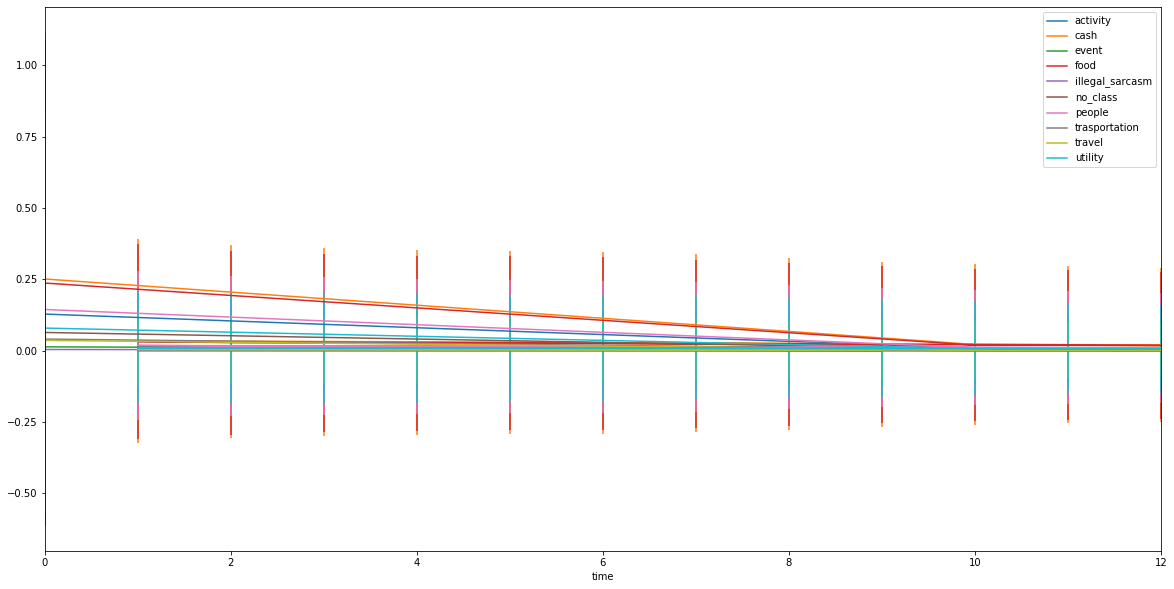

In [0]:
# after lifetime 10, the means for all categories' spendings tend to be stable and close to zero. 
fig, ax = plt.subplots(figsize=(20, 10))

for key, group in df_dynamic_summary.groupby('category'):
    group.plot('time', 'mean', yerr='2std', label=key, ax=ax) 

plt.show()

# Part 2: Social network analytics 

## Q5 Find a user’s friends and friends of friends 

In [0]:
edges = spark.sql("select user1 as userA, user2 as userB \
                   from \
                    (select distinct user1, user2 from Venmo \
                    union select distinct user2, user1 from Venmo) T\
                   order by userA")

edges.createOrReplaceTempView("edges")
edges.show()

In [0]:
df_friends = spark.sql("select e1.userA, e1.userB, e2.userB as userC \
                        from edges e1 join edges e2 on e1.userB=e2.userA \
                        order by e1.userA")

df_friends.createOrReplaceTempView("df_friends")
df_friends.show()

Describe your algorithm and calculate its computational complexity. Can you do it better?

## Q6 Use the dynamic analysis from before, and calculate the social network metrics across a user’s lifetime in Venmo 

**i) Number of friends and number of friends of friends**

In [0]:
df_countfriends = spark.sql("select userA, count(*) over(partition by userA) as friends_cnt, \
                                 count(*) as fof_cnt \
                             from df_friends \
                             group by userA, userB")
df_countfriends.show()

**ii) Clustering coefficient of a user's network**

**iii) Calculate the page rank of each user**

# Part 3: Predictive analytics with MLlib 

## Q7 Create dependent variable Y - the total number of transactions during her/his twelve months in Venmo

In [0]:
# calculate total number of transactions for each user on Venmo
df_y = spark.sql("select user1, count(*) as y from lifetime_tbl group by user1")
df_y.createOrReplaceTempView("df_y")
df_y.show()

+-----+---+
|user1|  y|
+-----+---+
| 2866|  1|
| 6620|  1|
|28170|  1|
|28759|  4|
|29894|  2|
|33602|  3|
|36525|  3|
|47283|  2|
|51415|  5|
|53963|  1|
|59990|  3|
|63087|  3|
|64423|  1|
|65408|  1|
|67492| 12|
|67861|  2|
|68202|  1|
|71995|  1|
|72758|  2|
|74775|  2|
+-----+---+
only showing top 20 rows



## Q8 Create the recency and frequency variables 

In [0]:
# create dataframe with two columns: user1 and time_list (0-12)
# each user has lifetime 0 to 12
lst = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_timelst = df_y.withColumn("time_lst", F.array([F.lit(x) for x in lst]))
df_timelst = df_timelst.withColumn("time_lst", F.explode(col("time_lst")))

# summarize number of transactions and the last transaction day in each lifetime period
df_summary = spark.sql("select user1, lifetime_indicator, count(*) as freq_times, max(days) as max_days \
           from lifetime_tbl \
           group by user1, lifetime_indicator")

df_timelst.createOrReplaceTempView("df_timelst")
df_summary.createOrReplaceTempView("df_summary")

In [0]:
# union dataframes and remove duplicated lifetime
df_distinct_summary = spark.sql("select user1, lifetime_indicator, max(max_days) as max_days, \
                        max(freq_times) as freq_times \
                  from \
                      (select user1, lifetime_indicator, max_days, freq_times from df_summary \
                      union  \
                      select user1, time_lst, null as max_days, null as freq_times from df_timelst) T \
                  group by user1, lifetime_indicator \
                  order by user1, lifetime_indicator ")

df_distinct_summary.createOrReplaceTempView("df_distinct_summary")
df_distinct_summary.show()

+-----+------------------+--------+----------+
|user1|lifetime_indicator|max_days|freq_times|
+-----+------------------+--------+----------+
|    2|                 0|       0|         1|
|    2|                 1|    null|      null|
|    2|                 2|    null|      null|
|    2|                 3|    null|      null|
|    2|                 4|    null|      null|
|    2|                 5|    null|      null|
|    2|                 6|    null|      null|
|    2|                 7|    null|      null|
|    2|                 8|    null|      null|
|    2|                 9|    null|      null|
|    2|                10|    null|      null|
|    2|                11|    null|      null|
|    2|                12|    null|      null|
|    3|                 0|       0|         2|
|    3|                 1|      17|         5|
|    3|                 2|    null|      null|
|    3|                 3|    null|      null|
|    3|                 4|    null|      null|
|    3|      

In [0]:
# calculate frequency and recency
# frequency: how often a user uses Venmo in a month. It is standardized and equals to (number of transactions/30)
# recency: the last time a user was active
    #if a user has used Venmo twice during her first month in Venmo with the second time being on day x, 
    #then her recency in month 1 is “30-x”

df_x = spark.sql("select user1, lifetime_indicator, max_days, \
                ifnull(freq_times, 0)/30 as frequency, \
                (lifetime_indicator*30-max(max_days) \
                    over(partition by user1 \
                         order by lifetime_indicator asc \
                         range between unbounded preceding and current row)) as recency \
              from df_distinct_summary \
              order by user1, lifetime_indicator")

df_x.createOrReplaceTempView("df_x")
df_x.show(60)

+-----+------------------+--------+-------------------+-------+
|user1|lifetime_indicator|max_days|          frequency|recency|
+-----+------------------+--------+-------------------+-------+
|    2|                 0|       0|0.03333333333333333|      0|
|    2|                 1|    null|                0.0|     30|
|    2|                 2|    null|                0.0|     60|
|    2|                 3|    null|                0.0|     90|
|    2|                 4|    null|                0.0|    120|
|    2|                 5|    null|                0.0|    150|
|    2|                 6|    null|                0.0|    180|
|    2|                 7|    null|                0.0|    210|
|    2|                 8|    null|                0.0|    240|
|    2|                 9|    null|                0.0|    270|
|    2|                10|    null|                0.0|    300|
|    2|                11|    null|                0.0|    330|
|    2|                12|    null|     

## Q9 For each user’s lifetime point, regress recency and frequency on ​Y. Plot the MSE for each lifetime point 

In [0]:
# join tables to combine user lifetime, frequency, recency and number of total transactions (y)
df_input = spark.sql("select user1, lifetime_indicator, frequency, recency, y \
                  from df_x join df_y using (user1) \
                  order by user1, lifetime_indicator")
df_input.createOrReplaceTempView("df_input")
df_input.show()

+-----+------------------+-------------------+-------+---+
|user1|lifetime_indicator|          frequency|recency|  y|
+-----+------------------+-------------------+-------+---+
|    2|                 0|0.03333333333333333|      0|  1|
|    2|                 1|                0.0|     30|  1|
|    2|                 2|                0.0|     60|  1|
|    2|                 3|                0.0|     90|  1|
|    2|                 4|                0.0|    120|  1|
|    2|                 5|                0.0|    150|  1|
|    2|                 6|                0.0|    180|  1|
|    2|                 7|                0.0|    210|  1|
|    2|                 8|                0.0|    240|  1|
|    2|                 9|                0.0|    270|  1|
|    2|                10|                0.0|    300|  1|
|    2|                11|                0.0|    330|  1|
|    2|                12|                0.0|    360|  1|
|    3|                 0|0.06666666666666667|      0|  

In [0]:
df_input_time0 = spark.sql("select * from df_input where lifetime_indicator=0 ")
df_input_time1 = spark.sql("select * from df_input where lifetime_indicator=1 ")
df_input_time2 = spark.sql("select * from df_input where lifetime_indicator=2 ")
df_input_time3 = spark.sql("select * from df_input where lifetime_indicator=3 ")
df_input_time4 = spark.sql("select * from df_input where lifetime_indicator=4 ")
df_input_time5 = spark.sql("select * from df_input where lifetime_indicator=5 ")
df_input_time6 = spark.sql("select * from df_input where lifetime_indicator=6 ")
df_input_time7 = spark.sql("select * from df_input where lifetime_indicator=7 ")
df_input_time8 = spark.sql("select * from df_input where lifetime_indicator=8 ")
df_input_time9 = spark.sql("select * from df_input where lifetime_indicator=9 ")
df_input_time10 = spark.sql("select * from df_input where lifetime_indicator=10 ")
df_input_time11 = spark.sql("select * from df_input where lifetime_indicator=11 ")
df_input_time12 = spark.sql("select * from df_input where lifetime_indicator=12 ")

In [0]:
def lifetimeMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'frequency', 'recency'], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [0]:
MSE_time0 = lifetimeMSE(df_input_time0)
print(MSE_time0)
MSE_time1 = lifetimeMSE(df_input_time1)
print(MSE_time1)
MSE_time2 = lifetimeMSE(df_input_time2)
print(MSE_time2)
MSE_time3 = lifetimeMSE(df_input_time3)
print(MSE_time3)
MSE_time4 = lifetimeMSE(df_input_time4)
print(MSE_time4)
MSE_time5 = lifetimeMSE(df_input_time5)
print(MSE_time5)

7.652437351481585
6.691173069837235
6.446252930703639
5.932649981257501
5.4084412991178805
5.1461627088341375


In [0]:
# MSE_time6 = lifetimeMSE(df_input_time6)
# print(MSE_time6)
# MSE_time7 = lifetimeMSE(df_input_time7)
# print(MSE_time7)
# MSE_time8 = lifetimeMSE(df_input_time8)
# print(MSE_time8)
# MSE_time9 = lifetimeMSE(df_input_time9)
# print(MSE_time9)
MSE_time10 = lifetimeMSE(df_input_time10)
print(MSE_time10)
MSE_time11 = lifetimeMSE(df_input_time11)
print(MSE_time11)
MSE_time12 = lifetimeMSE(df_input_time12)
print(MSE_time12)

MSE = []
MSE_time0=7.652437351481585
MSE_time1=6.691173069837235
MSE_time2=6.446252930703639
MSE_time3=5.932649981257501
MSE_time4=5.4084412991178805
MSE_time5=5.1461627088341375
MSE_time6=4.598004098833828
MSE_time7=4.474719220817289
MSE_time8=4.212880388012137
MSE_time9=4.169087571580209

MSE.extend([MSE_time0, MSE_time1, MSE_time2, MSE_time3, MSE_time4, MSE_time5, MSE_time6, 
            MSE_time7, MSE_time8, MSE_time9, MSE_time10, MSE_time11, MSE_time12])
MSE

4.212880388012137
4.169087571580209


In [0]:
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, MSE, 'go--', linewidth=2, markersize=12) 

## Q10 For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y. Plot the MSE for each lifetime point like above

In [0]:
df_dycfull_profile = spark.sql("select user1, lifetime_indicator, max(frequency) as frequency, \
                    max(recency) as recency, max(ifnull(people,0)) as people, max(ifnull(food,0)) as food, \
                    max(ifnull(activity,0)) as activity, max(ifnull(event,0)) as event, \
                    max(ifnull(travel,0)) as travel, max(ifnull(cash,0)) as cash, \
                    max(ifnull(utility,0)) as utility, max(ifnull(trasportation,0)) as trasportation, \
                    max(ifnull(illegal_sarcasm,0)) as illegal_sarcasm, max(ifnull(no_class,0)) as no_class \
                  from \
                      (select *, null as frequency, null as recency from dynamic_profile \
                      union  \
                      select user1, lifetime_indicator, \
                          null,null,null,null,null,null,null,null,null,null, \
                          frequency, recency from df_input) T \
                  group by user1, lifetime_indicator \
                  order by user1, lifetime_indicator ")

df_dycfull_profile.createOrReplaceTempView("df_dycfull_profile")
df_dycfull_profile.show()

+-----+------------------+-------------------+-------+------+----+--------+-----+------+----+-------+-------------+---------------+--------+
|user1|lifetime_indicator|          frequency|recency|people|food|activity|event|travel|cash|utility|trasportation|illegal_sarcasm|no_class|
+-----+------------------+-------------------+-------+------+----+--------+-----+------+----+-------+-------------+---------------+--------+
|    2|                 0|0.03333333333333333|      0|   1.0| 0.0|     0.0|  0.0|   0.0| 0.0|    0.0|          0.0|            0.0|     0.0|
|    2|                 1|                0.0|     30|   0.0| 0.0|     0.0|  0.0|   0.0| 0.0|    0.0|          0.0|            0.0|     0.0|
|    2|                 2|                0.0|     60|   0.0| 0.0|     0.0|  0.0|   0.0| 0.0|    0.0|          0.0|            0.0|     0.0|
|    2|                 3|                0.0|     90|   0.0| 0.0|     0.0|  0.0|   0.0| 0.0|    0.0|          0.0|            0.0|     0.0|
|    2|      

In [0]:
df_dynamic_input = spark.sql("select * \
                  from df_dycfull_profile join df_y using (user1) \
                  order by user1, lifetime_indicator")

df_dynamic_input.createOrReplaceTempView("df_dynamic_input")

In [0]:
df_dynamic_input_time0 = spark.sql("select * from df_dynamic_input where lifetime_indicator=0 ")
df_dynamic_input_time1 = spark.sql("select * from df_dynamic_input where lifetime_indicator=1 ")
df_dynamic_input_time2 = spark.sql("select * from df_dynamic_input where lifetime_indicator=2 ")
df_dynamic_input_time3 = spark.sql("select * from df_dynamic_input where lifetime_indicator=3 ")
df_dynamic_input_time4 = spark.sql("select * from df_dynamic_input where lifetime_indicator=4 ")
df_dynamic_input_time5 = spark.sql("select * from df_dynamic_input where lifetime_indicator=5 ")
df_dynamic_input_time6 = spark.sql("select * from df_dynamic_input where lifetime_indicator=6 ")
df_dynamic_input_time7 = spark.sql("select * from df_dynamic_input where lifetime_indicator=7 ")
df_dynamic_input_time8 = spark.sql("select * from df_dynamic_input where lifetime_indicator=8 ")
df_dynamic_input_time9 = spark.sql("select * from df_dynamic_input where lifetime_indicator=9 ")
df_dynamic_input_time10 = spark.sql("select * from df_dynamic_input where lifetime_indicator=10 ")
df_dynamic_input_time11 = spark.sql("select * from df_dynamic_input where lifetime_indicator=11 ")
df_dynamic_input_time12 = spark.sql("select * from df_dynamic_input where lifetime_indicator=12 ")

In [0]:
df_dynamic_input_time0.columns

In [0]:
def dynamicMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'people', 'food', 
                            'activity', 'event', 'travel', 'trasportation', 'cash',
                            'utility', 'illegal_sarcasm', 'no_class', 'frequency', 'recency'], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [0]:
dynamic_MSE = []
dynamic_MSE_time0 = dynamicMSE(df_dynamic_input_time0)
print(dynamic_MSE_time0)
dynamic_MSE_time1 = dynamicMSE(df_dynamic_input_time1)
print(dynamic_MSE_time1)
dynamic_MSE_time2 = dynamicMSE(df_dynamic_input_time2)
print(dynamic_MSE_time2)
dynamic_MSE_time3 = dynamicMSE(df_dynamic_input_time3)
print(dynamic_MSE_time3)
dynamic_MSE_time4 = dynamicMSE(df_dynamic_input_time4)
print(dynamic_MSE_time4)
dynamic_MSE_time5 = dynamicMSE(df_dynamic_input_time5)
print(dynamic_MSE_time5)
dynamic_MSE_time6 = dynamicMSE(df_dynamic_input_time6)
print(dynamic_MSE_time6)
dynamic_MSE_time7 = dynamicMSE(df_dynamic_input_time7)
print(dynamic_MSE_time7)
dynamic_MSE_time8 = dynamicMSE(df_dynamic_input_time8)
print(dynamic_MSE_time8)
dynamic_MSE_time9 = dynamicMSE(df_dynamic_input_time9)
print(dynamic_MSE_time9)
dynamic_MSE_time10 = dynamicMSE(df_dynamic_input_time10)
print(dynamic_MSE_time10)
dynamic_MSE_time11 = dynamicMSE(df_dynamic_input_time11)
print(dynamic_MSE_time11)
dynamic_MSE_time12 = dynamicMSE(df_dynamic_input_time12)
print(dynamic_MSE_time12)

dynamic_MSE.extend([dynamic_MSE_time0, dynamic_MSE_time1, dynamic_MSE_time2, 
                    dynamic_MSE_time3, dynamic_MSE_time4, dynamic_MSE_time5, 
                    dynamic_MSE_time6, dynamic_MSE_time7, dynamic_MSE_time8, 
                    dynamic_MSE_time9, dynamic_MSE_time10, dynamic_MSE_time11, 
                    dynamic_MSE_time12])
dynamic_MSE

In [0]:
plt.plot(Lifetime, dynamic_MSE, 'b--o', color='darkred', linewidth=2, markersize=12) 

## Q11 For each user’s lifetime point, regress her social network metrics on Y. Plot the MSE for each lifetime point like above

## Q12 For each user’s lifetime point, regress her social network metrics and the spending behavior of her social network on Y. Plot the MSE for each lifetime point like above